In [ ]:
import numpy as np
from tqdm import tqdm
import cv2
import os
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:
TRAIN_DIR = ('../input/facial-recognition-dataset/Training/Training/')
TEST_DIR = ('../input/facial-recognition-dataset/Testing/Testing/')

def load_data(dir_path, IMG_SIZE):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = img.astype('float32') / 255
                    resized = cv2.resize(img, IMG_SIZE, interpolation = cv2.INTER_AREA)
                    X.append(resized)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [ ]:
IMG_SIZE= (48, 48)
X_train, y_train, train_labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, test_labels = load_data(TEST_DIR, IMG_SIZE)

NUM_CLASSES = len(train_labels)
Y_train = tf.keras.utils.to_categorical(y_train, num_classes=NUM_CLASSES)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes=NUM_CLASSES)

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

100%|██████████| 6/6 [00:07<00:00,  1.19s/it]


28273 images loaded from ../input/facial-recognition-dataset/Training/Training/ directory.


100%|██████████| 6/6 [00:00<00:00,  7.36it/s]

7067 images loaded from ../input/facial-recognition-dataset/Testing/Testing/ directory.


In [ ]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SIZE + (3,)
)

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6)
]

epochs = 50
batch_size = 64

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    validation_data=(X_test, Y_test),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

save_path = 'facial_emotion_model.keras'
model.save(save_path)
print("Model saved successfully at:", save_path)

Epoch 1/50
441/441 [==============================] - 57s 101ms/step - loss: 1.7942 - accuracy: 0.2958 - val_loss: 1.4537 - val_accuracy: 0.4306 - lr: 1.0000e-04
Epoch 2/50
441/441 [==============================] - 43s 98ms/step - loss: 1.4527 - accuracy: 0.4168 - val_loss: 1.3249 - val_accuracy: 0.4929 - lr: 1.0000e-04
Epoch 3/50
441/441 [==============================] - 53s 121ms/step - loss: 1.3027 - accuracy: 0.4922 - val_loss: 1.2183 - val_accuracy: 0.5163 - lr: 1.0000e-04
Epoch 4/50
441/441 [==============================] - 41s 93ms/step - loss: 1.2246 - accuracy: 0.5311 - val_loss: 1.2501 - val_accuracy: 0.5257 - lr: 1.0000e-04
Epoch 5/50
441/441 [==============================] - 42s 95ms/step - loss: 1.1769 - accuracy: 0.5549 - val_loss: 1.1048 - val_accuracy: 0.5679 - lr: 1.0000e-04
Epoch 6/50
441/441 [==============================] - 43s 98ms/step - loss: 1.1137 - accuracy: 0.5768 - val_loss: 1.0263 - val_accuracy: 0.6083 - lr: 1.0000e-04
Epoch 7/50
441/441 [============

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

final_train_accuracy = train_accuracy[-1]
final_val_accuracy = val_accuracy[-1]

print('Final Training Accuracy:', final_train_accuracy)
print('Final Validation Accuracy:', final_val_accuracy)

Final Training Accuracy: 0.814314603805542
Final Validation Accuracy: 0.6874204277992249


221/221 [==============================] - 3s 12ms/step
Test Accuracy = 0.67


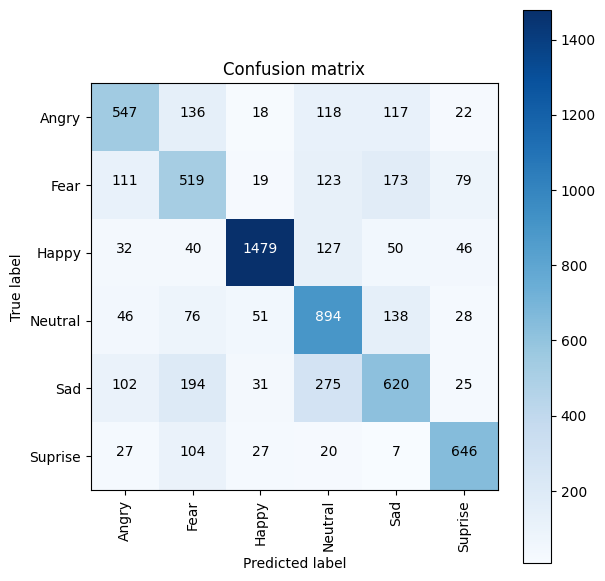

In [ ]:
predictions = model.predict(X_test)
y_pred = [np.argmax(probas) for probas in predictions]

accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, y_pred)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = plot_confusion_matrix(confusion_mtx, classes=list(test_labels.values()), normalize=False)


In [ ]:
def preprocess_image(image_path, IMG_SIZE):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype('float32') / 255
    return img.reshape(1, *IMG_SIZE, 3)

model_path = 'facial_emotion_model.keras'
model = load_model(model_path)

def predict_image(image_path, model, labels):
    IMG_SIZE = (48, 48)
    img = preprocess_image(image_path, IMG_SIZE)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]
    label = labels[predicted_class]
    return label, confidence, img.reshape(*IMG_SIZE, 3)

def get_random_image_from_directory(directory):
    class_dir = random.choice([os.path.join(directory, d) for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
    image_path = random.choice([os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
    true_label = os.path.basename(class_dir)
    return image_path, true_label

def predict_random_image(directory, model, labels):
    image_path, true_label = get_random_image_from_directory(directory)
    predicted_label, confidence, image = predict_image(image_path, model, labels)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

train_labels = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

TEST_DIR = '../input/facial-recognition-dataset/Testing/Testing/'

1/1 [==============================] - 0s 19ms/step


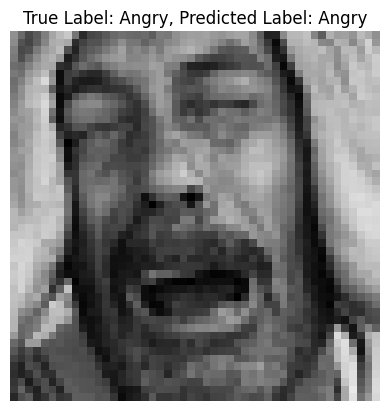

In [ ]:
predict_random_image(TEST_DIR, model, train_labels)

1/1 [==============================] - 0s 17ms/step


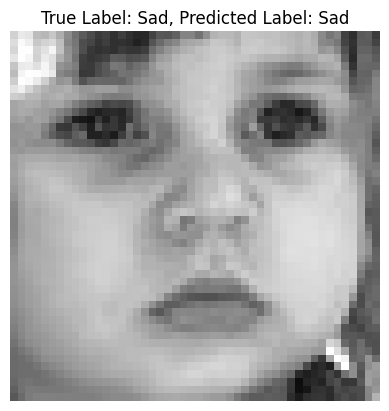

In [ ]:
predict_random_image(TEST_DIR, model, train_labels)

1/1 [==============================] - 0s 18ms/step


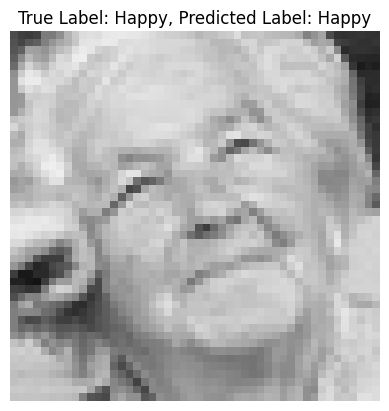

In [ ]:
predict_random_image(TEST_DIR, model, train_labels)

1/1 [==============================] - 0s 18ms/step


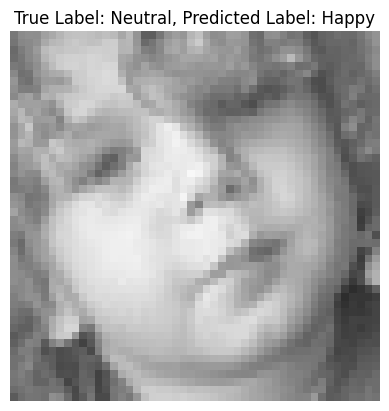

In [ ]:
predict_random_image(TEST_DIR, model, train_labels)

1/1 [==============================] - 0s 17ms/step


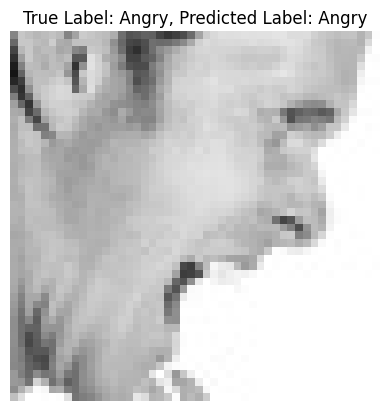

In [ ]:
predict_random_image(TEST_DIR, model, train_labels)